
## Objective:

We want to implement a Convolutional Neural Network (CNN) to do image super-resolution.

## Image super-resolution:

The super-resolution problem can be summarised as follows. We have an image as an input, which is defined over a grid $\{0,1,\dots, m-1\} \times \{0,1,\dots, n-1\}$. We define a factor $\delta$, by which we upsample the image. The output of the super-resolution is an image defined on the grid $\{0,\frac{1}{\delta},\dots, m-1\} \times \{0,\frac{1}{\delta},\dots, n-1\}$.


## Dataset

We will be using the mnist dataset for this part.  The input data should be the subsampled version of the mnist images, subsampled by taking one out of every $\delta$ pixels. The output data should be the normal-resolution mnist images.






We are aiming an accuracy of about  $80\%$


In [1]:

# # Load packages

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import optimizers
from scipy import interpolate
print(tf.keras.__version__)

2.7.0


In [2]:
# choice of the interpolation method
interp_method = 'linear'
# upsampling factor
delta = 2
# the maximum number of data to take from mnist (to go a bit faster)
n_max = 5000

# upsample by a factor of delta
# by definition, the new grid has a step size of 1/delta
def super_res_interpolate(imgs_in,delta,interp_method = 'linear'):
	imgs_out = tf.image.resize( tf.constant(imgs_in),\
		[delta*imgs_in.shape[1],delta*imgs_in.shape[2]], method='bilinear').numpy()

	return(imgs_out)


# 1) Importing MNIST

In [3]:
from keras.datasets import mnist
from tensorflow.keras.layers import UpSampling2D
Y_train, Y_test = mnist.load_data()

Y_train= Y_train[0]
Y_test = Y_test[0]

Y_train = Y_train[0:n_max,:,:]
Y_test = Y_test[0:n_max,:,:]


print(Y_train.shape)
print(Y_test.shape)

img_rows, img_cols, nb_channels = Y_train.shape[1], Y_train.shape[2], 1

# In case depth is 1 (black and white pictures) -> reshape to proper format
Y_train = Y_train.reshape(Y_train.shape[0], img_rows, img_cols, nb_channels)
Y_test = Y_test.reshape(Y_test.shape[0], img_rows, img_cols, nb_channels)

Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')
Y_train /= 255
Y_test /= 255

print(Y_train.shape)
print(Y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(5000, 28, 28)
(5000, 28, 28)
(5000, 28, 28, 1)
(5000, 28, 28, 1)


### Function used to subsample images :




In [4]:
def sub_sampling_images(Y, delta):
  X=[]

  for img in Y:
    h, w, c = img.shape
    new_height = int(h / delta)
    new_width = int(w / delta)
            
    # Resize down the image
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
            

    X.append(img)
  
  return np.array(X)



### Building training data

In [5]:
X_train = sub_sampling_images(Y_train, delta)
X_test = sub_sampling_images(Y_test, delta)

img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], 1

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

print(X_train.shape)

(5000, 14, 14, 1)


### Visualization

Text(0.5, 1.0, 'Original image')

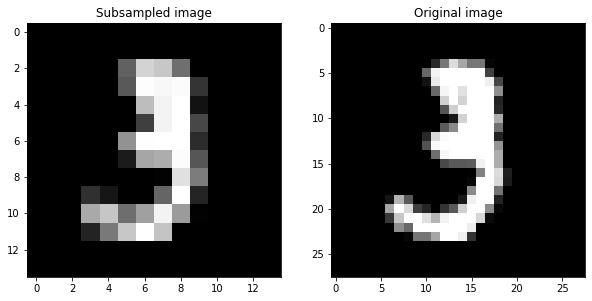

In [6]:
fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 2

fig.add_subplot(rows, columns,1)
plt.imshow(X_train[10].reshape(14,14),cmap='gray')
plt.title("Subsampled image")

fig.add_subplot(rows, columns,2)
plt.imshow(Y_train[10].reshape(28,28),cmap='gray')
plt.title("Original image")

# 2) Creating the model 

In [7]:
model = Sequential()
model.add(Input(shape=(14,14,1)))
model.add(UpSampling2D(delta))
model.add(Conv2D(filters=128, kernel_size=(9, 9), padding='same',input_shape=(28,28,1),strides=(1, 1),name="Conv1"))
model.add(Activation("relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(28,28,1),padding="same",strides=(1, 1),name="Conv2"))
model.add(Activation("relu"))
model.add(Conv2D(1, kernel_size=(5,5),input_shape=(28,28,1),padding="same",strides=(1, 1), name="Conv3"))
model.add(Activation("linear"))

model.compile(optimizer="adam", loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 28, 28, 1)        0         
 )                                                               
                                                                 
 Conv1 (Conv2D)              (None, 28, 28, 128)       10496     
                                                                 
 activation (Activation)     (None, 28, 28, 128)       0         
                                                                 
 Conv2 (Conv2D)              (None, 28, 28, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 28, 28, 1)         1601      
                                                        

# 3) Training the model

In [8]:
model.fit(X_train,Y_train,epochs=10,batch_size=64)

Epoch 1/10
79/79 [==============================] - 16s 11ms/step - loss: 0.0129 - accuracy: 0.8139
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0046 - accuracy: 0.8154
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0034 - accuracy: 0.8154
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - accuracy: 0.8154
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0025 - accuracy: 0.8154
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0023 - accuracy: 0.8154
Epoch 7/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0022 - accuracy: 0.8154
Epoch 8/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0021 - accuracy: 0.8154
Epoch 9/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 0.8154
Epoch 10/10
79/79 [==============================] - 1s 10ms/step - loss: 0.0020 - accuracy: 0.8154


### Prediction on test data

In [9]:
y_hat = model.predict(X_test)

### Accuracy

In [10]:

print("Accuracy = "+str(model.evaluate(X_test,Y_test)[1]))


157/157 [==============================] - 1s 3ms/step - loss: 0.0020 - accuracy: 0.8242
Accuracy = 0.8241921067237854


# Visualization

Text(0.5, 1.0, 'sub image')

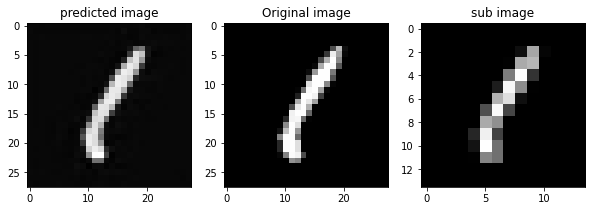

In [11]:
y_hat = model.predict(X_test)

fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 3

fig.add_subplot(rows, columns,1)
plt.imshow(y_hat[107].reshape(28,28),cmap='gray')
plt.title("predicted image")

fig.add_subplot(rows, columns,2)
plt.imshow(Y_test[107].reshape(28,28),cmap='gray')
plt.title("Original image")

fig.add_subplot(rows, columns,3)
plt.imshow(X_test[107].reshape(14,14),cmap='gray')
plt.title("sub image")